In [30]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt

### Load our (merged) song dataset

In [3]:
songs_df = pd.read_csv('songs.csv')
songs_df

,artist,title,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,hot
0,Taylor Swift,Anti-Hero,0.637,0.643,4,-6.571,1,0.0519,0.1300,0.000002,...,0.5330,97.008,audio_features,0V3wPSX9ygBnCm8psDIegu,spotify:track:0V3wPSX9ygBnCm8psDIegu,https://api.spotify.com/v1/tracks/0V3wPSX9ygBn...,https://api.spotify.com/v1/audio-analysis/0V3w...,200690,4,1
1,Taylor Swift,Lavender Haze,0.733,0.436,10,-10.489,1,0.0800,0.2580,0.000573,...,0.0976,96.985,audio_features,5jQI2r1RdgtuT8S3iG8zFC,spotify:track:5jQI2r1RdgtuT8S3iG8zFC,https://api.spotify.com/v1/tracks/5jQI2r1Rdgtu...,https://api.spotify.com/v1/audio-analysis/5jQI...,202396,4,1
2,Taylor Swift,Maroon,0.637,0.398,7,-8.294,1,0.0564,0.0573,0.000001,...,0.0374,108.075,audio_features,3eX0NZfLtGzoLUxPNvRfqm,spotify:track:3eX0NZfLtGzoLUxPNvRfqm,https://api.spotify.com/v1/tracks/3eX0NZfLtGzo...,https://api.spotify.com/v1/audio-analysis/3eX0...,218271,4,1
3,Taylor Swift,Midnight Rain,0.643,0.363,0,-11.738,1,0.0767,0.6900,0.000052,...,0.2300,139.865,audio_features,3rWDp9tBPQR9z6U5YyRSK4,spotify:track:3rWDp9tBPQR9z6U5YyRSK4,https://api.spotify.com/v1/tracks/3rWDp9tBPQR9...,https://api.spotify.com/v1/audio-analysis/3rWD...,174783,4,1
4,Taylor Swift,Bejeweled,0.700,0.550,7,-9.130,1,0.0653,0.0661,0.000102,...,0.4120,164.003,audio_features,0jvo9CjnbR0lYUDTSNTMiu,spotify:track:0jvo9CjnbR0lYUDTSNTMiu,https://api.spotify.com/v1/tracks/0jvo9CjnbR0l...,https://api.spotify.com/v1/audio-analysis/0jvo...,194166,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2294,Daniel Norgren,Moonshine Got Me,0.458,0.497,8,-9.660,1,0.0479,0.7160,0.155000,...,0.1440,107.748,audio_features,6LrxNNCaqssGmyCGi1EPJA,spotify:track:6LrxNNCaqssGmyCGi1EPJA,https://api.spotify.com/v1/tracks/6LrxNNCaqssG...,https://api.spotify.com/v1/audio-analysis/6Lrx...,531333,4,0
2295,Dover,Serenade me,0.524,0.776,5,-6.193,0,0.0404,0.0330,0.000022,...,0.3010,123.622,audio_features,4tzi4VV1vCTZsT4SEKQIKJ,spotify:track:4tzi4VV1vCTZsT4SEKQIKJ,https://api.spotify.com/v1/tracks/4tzi4VV1vCTZ...,https://api.spotify.com/v1/audio-analysis/4tzi...,234280,4,0
2296,Queen,I want it all,0.402,0.835,11,-5.734,0,0.0500,0.0287,0.000003,...,0.4300,92.029,audio_features,5AaGovcNgVcreY5GHmv3u3,spotify:track:5AaGovcNgVcreY5GHmv3u3,https://api.spotify.com/v1/tracks/5AaGovcNgVcr...,https://api.spotify.com/v1/audio-analysis/5AaG...,241253,4,0
2297,Sultans of Ping FC,Where's me jumper?,0.395,0.914,11,-6.706,0,0.1590,0.0728,0.000000,...,0.4350,174.284,audio_features,1PWkvrHtJI1TLfnZDWDf2u,spotify:track:1PWkvrHtJI1TLfnZDWDf2u,https://api.spotify.com/v1/tracks/1PWkvrHtJI1T...,https://api.spotify.com/v1/audio-analysis/1PWk...,189213,4,0


### Decided to use the following 10 features for fitting our clustering models:
* danceability
* energy
* key
* loudness
* speechiness
* acousticness
* instrumentalness
* liveness
* valence
* tempo

In [4]:
numerical_df = songs_df.select_dtypes(np.number)
X = numerical_df.drop(['mode', 'duration_ms', 'time_signature', 'hot'], axis=1)
X.describe()

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,2299.000000,2299.000000,2299.000000,2299.000000,2299.000000,2299.000000,2299.000000,2299.000000,2299.000000,2299.000000
mean,0.603672,0.595231,5.073945,-9.054452,0.060825,0.333831,0.060518,0.185897,0.604919,118.367838
std,0.162868,0.229733,3.568638,3.837153,0.062196,0.321120,0.186724,0.155202,0.252399,26.882526
min,0.000000,0.019000,0.000000,-37.841000,0.000000,0.000011,0.000000,0.012400,0.000000,0.000000
25%,0.500000,0.445000,2.000000,-11.410500,0.031800,0.048100,0.000000,0.088100,0.403500,99.412500
50%,0.622000,0.625000,5.000000,-8.620000,0.039900,0.210000,0.000027,0.128000,0.632000,117.046000
75%,0.722000,0.777000,8.000000,-6.214000,0.060000,0.593000,0.002465,0.242000,0.819500,132.069000
max,0.979000,0.997000,11.000000,-0.810000,0.817000,0.996000,0.985000,0.989000,0.986000,210.857000


In [31]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)


In [60]:
model = DBSCAN(eps=3.5, min_samples=20)
yhat  = model.fit_predict(X_scaled)
clusters = np.unique(yhat)

pd.Series(yhat).value_counts()

 0    2276
-1      23
dtype: int64

In [6]:
X_df = X.copy()
X_df['cluster'] = yhat


## Fine tuning

In order to find out the best value for, we follow these steps:

    1. Compute the distance matrix between the all the observations
    2. We fix the number of nearest neighbours k > 2.
    3. We get all the distances from each point to it's k-nearest-neighbour.
    4. We sort all those distances in descending order.
    5. We plot those distances.

#### Step 1

In [12]:
d = distance_matrix(X,X)
print(d)

[[ 0.          7.18403021 11.60861098 ...  8.64077672 77.59352448
  12.76443208]
 [ 7.18403021  0.         11.6989052  ...  6.97543372 77.40119263
  14.6025377 ]
 [11.60861098 11.6989052   0.         ... 16.74841962 66.3524504
   6.79661031]
 ...
 [ 8.64077672  6.97543372 16.74841962 ...  0.         82.26127613
  20.03864786]
 [77.59352448 77.40119263 66.3524504  ... 82.26127613  0.
  66.78205327]
 [12.76443208 14.6025377   6.79661031 ... 20.03864786 66.78205327
   0.        ]]


#### Step 2
We need to sort this matrix by row and to ignore the first element as it is the distance to every point to itself (ie. 0)

In [13]:
d2 = np.sort(d)[:,1:]
print(d2)

[[  0.56307999   0.708262     1.04675752 ... 111.55704387 112.11424988
  113.88817876]
 [  1.02198674   1.10887369   1.31735402 ... 111.42776079 112.41636365
  114.31746236]
 [  0.84159538   0.88897254   1.08447647 ... 101.15413231 102.97996867
  108.31866907]
 ...
 [  0.88658204   1.68839715   1.86325072 ... 116.76769544 117.50449579
  119.17648426]
 [  1.64835719   2.07619466   2.25358908 ... 121.40173638 131.08573629
  174.66415118]
 [  1.28237325   1.52951509   1.68897895 ... 100.6229762  102.67530666
  108.44264161]]


#### Step 3
We select the k-th column, for example k = 19 (ie. the distance from each point to it's 20-th nearest neighbourgh.

In [14]:
f = d2[:,19]
print(f) # The distances between every point and it's 20th nearest neighbour.
max(f)

[2.95301158 2.74956951 2.51860634 ... 3.88641072 5.21681124 2.68510089]


69.49068913885947

#### Step 4

We sort the 3-th distances in descending order.


In [15]:
f_final = np.sort(f)[::-1]
print()
print(f_final)


[69.49068914 27.05992602 26.8969064  ...  2.1573408   2.13534956
  2.13067922]


#### Step 5

We plot those distances.

MinPoints = 10 * 2 = 20

/tmp/ipykernel_1893/1178530142.py:9: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True)


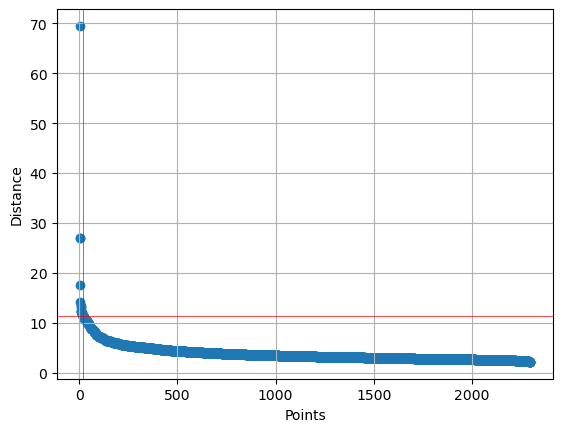

In [25]:
plt.scatter(range(1,len(f_final)+1), f_final)
plt.xlabel("Points")
plt.ylabel("Distance")
# Current selected settings for DBSCAN
xnew = 20
ynew = f_final[19]
plt.axvline(xnew, color='red', linewidth=0.5)
plt.axhline(ynew, color='red', linewidth=0.5)
plt.grid(b=True)
plt.show()

In [17]:
f_final[8]

12.294170031376657

In [26]:
f_final[19]

11.325656488257094

In [27]:
model2 = DBSCAN(eps=11.32, min_samples=20) # eps was 0.30 before
# fit model and predict clusters
yhat2 = model2.fit_predict(X)

# retrieve unique clusters
clusters2 = np.unique(yhat2)
clusters2


array([-1,  0])